### Imputation Method 

Compare different imputation methods for different windows of imputation. 

In [1]:
# Setup
import numpy as np
import pickle
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.express as px
from pathlib import Path
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from statsforecast import StatsForecast
from statsforecast.models import AutoETS
from prophet import Prophet

# Multiple outputs per cell
%config InteractiveShell.ast_node_interactivity = 'all'

# Functions
def create_hour_minute(df):
    '''
    This function is supplemental to the following 'add_time_features' function,
    creating an hour_minute variable
    '''
    # Initialize empty variable
    df['hour_minute'] = None

    # Conditions
    conditions = [df['utc_timestamp'].dt.minute == 15,
                  df['utc_timestamp'].dt.minute == 30,
                  df['utc_timestamp'].dt.minute == 45]
    
    transform = [df['utc_timestamp'].dt.hour + .25,
                 df['utc_timestamp'].dt.hour + .5,
                 df['utc_timestamp'].dt.hour + .75]
    
    # given conditions, transform 
    converted_times = np.select(conditions, transform, df['utc_timestamp'].dt.hour)

    return converted_times

def create_impute_groups(data, y):
    '''
    Given dataframe with variable to impute, returns 
    a group number for that NA, how many consecutive
    NAs there are, and the first + last index values of 
    the consecutive NAs
    '''
    # note NA values in dataframe
    df = (data.set_index('utc_timestamp') # data or self.data
            .isna()
            .reset_index(drop=True)
          )
    
    # Assign groups of NAs a unique group number
    group_num = 0
    groups = [0]
    for i in range(len(df[y].values)-1): # y or self.y
        value = df[y].values[i]
        next_value = df[y].values[i+1]

        if value == False and next_value == True:
            group_num += 1
        if next_value == None:
            continue
        if value == False:
            groups.append(0)
        else: 
            groups.append(group_num)

    # Add na groups and index columns to df
    df['missing_group_num'] = groups 
    df['index'] = list(range(0, len(df)))

    missing_lengths = (df.groupby('missing_group_num', as_index=False)
                       .agg(consecutive = ('missing_group_num', 'count'),
                            first_na_idx = ('index', 'min'),
                            # adding 2 to last index for imputation
                            last_na_idx = ('index', lambda x: x.max() + 2)) 
                       .iloc[1:] # remove non_na groups
                       .sort_values('first_na_idx')
                       )
    
    return missing_lengths

In [2]:
# Read in data for developing imputation method
cd = Path.cwd()
data_dir = str(cd.parents[1])
load_energy_dt = data_dir + '/datasets/country_energy/country_load.pickle'

# Read pickle data 
with open(load_energy_dt, 'rb') as f:
    country_actuals = (pickle.load(f)[['utc_timestamp', 'country', 'load_actual_entsoe_transparency']])

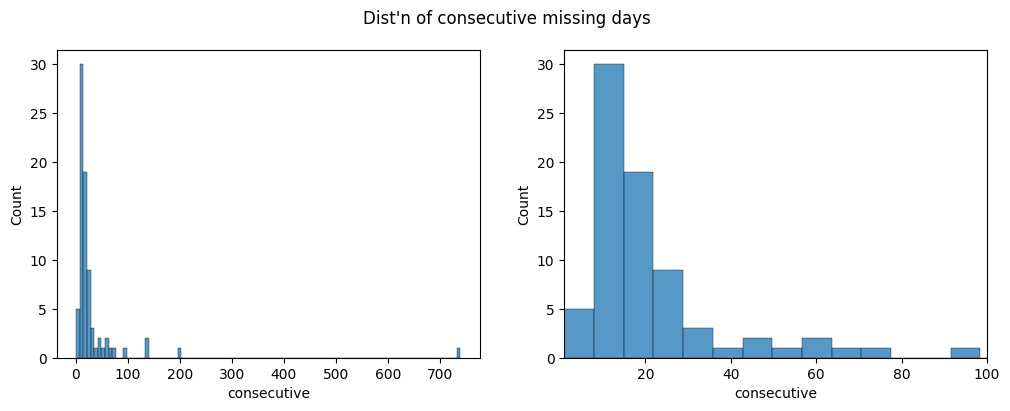

In [3]:
missing_lengths = create_impute_groups(country_actuals, 'load_actual_entsoe_transparency')

# Hist of missing lengths, omitting complete data
fig, ax = plt.subplots(1, 2, figsize=(12,4))
_ = sns.histplot(data=missing_lengths[1:], x='consecutive', stat='count', ax=ax[0])
_ = sns.histplot(data=missing_lengths[1:], x='consecutive', stat='count', ax=ax[1])
_ = ax[1].set_xlim(1,100)
_ = plt.suptitle("Dist'n of consecutive missing days")
plt.show()

In [4]:
country_actuals.head()

,utc_timestamp,country,load_actual_entsoe_transparency
151779,2014-12-31 23:15:00+00:00,NL,9819.0
151780,2014-12-31 23:30:00+00:00,NL,9790.0
151781,2014-12-31 23:45:00+00:00,NL,9718.0
151782,2015-01-01 00:00:00+00:00,NL,9622.0
151783,2015-01-01 00:15:00+00:00,NL,9524.0


In [5]:
test = country_actuals.set_index('utc_timestamp').isna().reset_index(drop=True)
test
group_num = 0 
groups = [0] ### --- Problem is that 'to_impute' must be hardcoded
for i in range(len(test['load_actual_entsoe_transparency'].values)-1): # y or self.y
    value = test['load_actual_entsoe_transparency'].values[i]
    next_value = test['load_actual_entsoe_transparency'].values[i+1]

    if value == False and next_value == True:
        group_num += 1
    if next_value == None:
        continue
    if value == False:
        groups.append(0)
    else: 
        groups.append(group_num)
# groups
sum(groups)
create_impute_groups(country_actuals, 'load_actual_entsoe_transparency')

,country,load_actual_entsoe_transparency
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
910669,False,False
910670,False,False
910671,False,False
910672,False,False


148672

,missing_group_num,consecutive,first_na_idx,last_na_idx
1,1,20,144923,144944
2,2,47,145536,145584
3,3,1,151779,151781
4,4,1,303558,303560
5,5,9,441138,441148
...,...,...,...,...
76,76,16,905955,905972
77,77,12,905991,906004
78,78,24,906011,906036
79,79,9,906062,906072


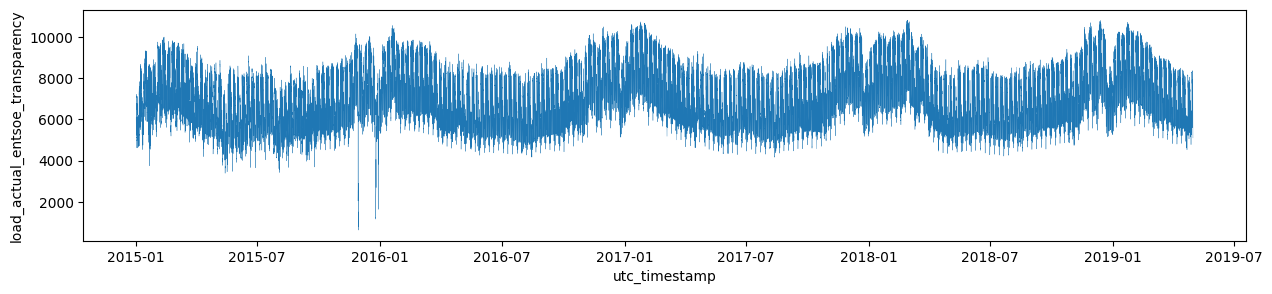

In [6]:
### Developing imputation algorithm with AT due 
# # to there being a full dataset
plot_dt = country_actuals.loc[lambda x: x.country == 'AT']

_ = plt.figure(figsize=(15, 3))

_ = sns.lineplot(
    data=plot_dt, 
    x='utc_timestamp', 
    y='load_actual_entsoe_transparency', 
    linewidth=0.25)

plt.show()

## Impute method comparison
- Select AT due to their being no NA values for imputation test
- Create window of size n: 2 through 96 (by 2)
    - Randomly sample 24 windows slightly larger than size n from dataset
    - Place n nans in dataset
    - Across the 24 windows, get average mae for a given imputation method
- Display table results of imputation methods across the windows
- Display plots of results comparing methods

### Loop parallelized with Ray

In [8]:
import ray

Without Class Structure

In [36]:
### For test, Limiting to AT due to no missing data

@ray.remote
def create_hour_minute(df):
    '''
    This function is supplemental to the following 'add_time_features' function,
    creating an hour_minute variable
    '''
    # Initialize empty variable
    df['hour_minute'] = None

    # Conditions
    conditions = [df['utc_timestamp'].dt.minute == 15,
                  df['utc_timestamp'].dt.minute == 30,
                  df['utc_timestamp'].dt.minute == 45]
    
    transform = [df['utc_timestamp'].dt.hour + .25,
                 df['utc_timestamp'].dt.hour + .5,
                 df['utc_timestamp'].dt.hour + .75]
    
    # given conditions, transform 
    converted_times = np.select(conditions, transform, df['utc_timestamp'].dt.hour)

    return converted_times

@ray.remote
def create_impute_data(data):
    # ---
    # --- modify to be effective for all countries
    # --- (currently limited to AT)
    impute_data = (data.assign(
            weekday = lambda x: x['utc_timestamp'].dt.strftime('%a'),
            hour_minute = lambda x: ray.get(create_hour_minute.remote(x)) # --- this function in not in ray remote
        )
        .loc[lambda x: x.country == 'AT']
        .reset_index(drop=True)
        ) 

    return impute_data

@ray.remote
def create_window_idx(data, num_windows=24):
    # indices to loop over for get mae across 24 samples
    impute_windows = list(data.sample(num_windows, random_state=24).index)
    return impute_windows

@ray.remote
def create_weekday_impute(data):

    # Weekday impute method
    weekday_impute = (data.groupby(['weekday', 'hour_minute'], as_index=False)
                    .agg(avg_weekday_actuals = ('load_actual_entsoe_transparency', lambda x: x.mean().round(2)))
                    )
    week_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    weekday_impute['weekday'] = pd.Categorical(
        weekday_impute['weekday'], 
        categories=week_order, 
        ordered=True
        )
    weekday_impute = weekday_impute.sort_values(by=['weekday','hour_minute'])
    
    return weekday_impute

In [38]:
# Goals: Resolve the following --- Solution may have been method of creating the fcst dataframe ---

@ray.remote
def create_impute_window(data, n, idx, forecast=False): 
    '''
    Creates imputation window, for NAs. 
    Window:
        1 row of available data, 
        n rows of NAs, 
        2 rows of available data
    
    This is done to ensure all imputation methods can impute without error
    '''

    window = data.iloc[idx-1:idx+n+2]
    window['to_impute'] = window['load_actual_entsoe_transparency'];  
    window.loc[idx:idx+n-1, 'to_impute'] = np.nan

    # forecast impute window, which has additional data for forcasting
    if forecast:
        ### Future: consider dynamic forecast window
        one_year_data = 2880 * 6 # Selecting all data available, up to 1 year
        fcst_start = max(idx - one_year_data, 0) 
        fcst_window = data.iloc[fcst_start:idx+n+2]
        fcst_window['to_impute'] = fcst_window['load_actual_entsoe_transparency'];  
        fcst_window.loc[idx:idx+n-1, 'to_impute'] = np.nan

        return fcst_window
    
    return window

@ray.remote
def create_impute_groups(data, y):
    '''
    Given dataframe with variable to impute, returns 
    a group number for that NA, how many consecutive
    NAs there are, and the first + last index values of 
    the consecutive NAs
    '''
    # note NA values in dataframe
    df = (data.set_index('utc_timestamp') # data or self.data
            .isna()
            .reset_index(drop=True)
          )
    
    # Assign groups of NAs a unique group number
    group_num = 0
    groups = [0]
    for i in range(len(df[y].values)-1): # y or self.y
        value = df[y].values[i]
        next_value = df[y].values[i+1]

        if value == False and next_value == True:
            group_num += 1
        if next_value == None:
            continue
        if value == False:
            groups.append(0)
        else: 
            groups.append(group_num)

    # Add na groups and index columns to df
    df['missing_group_num'] = groups 
    df['index'] = list(range(0, len(df)))

    missing_lengths = (df.groupby('missing_group_num', as_index=False)
                       .agg(consecutive = ('missing_group_num', 'count'),
                            first_na_idx = ('index', 'min'),
                            # adding 2 to last index for imputation
                            last_na_idx = ('index', lambda x: x.max() + 2)) 
                       .iloc[1:] # remove non_na groups
                       .sort_values('first_na_idx')
                       )
    
    return missing_lengths

@ray.remote
def forecast_impute(data, y, model_type='AutoETS'): # AutoETS AAA
    '''
    Given forecasting data and y, creates a forecast model
    with a horizon depending on the number of NAs needing
    imputation.
    Currently, can select 'AutoETS' or 'Prophet' as forecasting models.
    '''
    # from statsforecast import StatsForecast
    # from statsforecast.models import AutoETS
    data = data.reset_index(drop=True)
    impute_info = ray.get(create_impute_groups.remote(data, y))
        
    first_na = impute_info['first_na_idx'].iloc[0] 

    # Defining start, end, and horizon points of training window
    one_year_data = 2880 * 6 # Selecting all data available, up to 6 months
    start = max(first_na - one_year_data, 0)  
    end = first_na - 1 
    
    horizon = impute_info['consecutive'].iloc[0]
    fcst_df = (data.iloc[start:end] 
            .assign(index = 1) 
            [['index', 'utc_timestamp', y]]) # --- This needs to be generalized

    if model_type == 'AutoETS':
        pd.options.mode.chained_assignment = None

        fcst_df = (data.iloc[start:end] 
            .assign(index = 1) 
            [['index', 'utc_timestamp', y]])

        impute_model = StatsForecast(
            models=[AutoETS(model='AAA', season_length=96)], # --- season_length=96 (1 day) or maybe 1 week
            freq='15min', # --- Needs generalizaiton
            n_jobs=-1,
            verbose=False
            ) 

        result = impute_model.forecast(
            df=fcst_df, 
            id_col='index',
            time_col='utc_timestamp', # --- Needs generalization 
            target_col=y, # --- Needs generalization
            h=horizon,
            # show progress = False,
            ).rename(columns={'AutoETS': 'imputed'})
        
        return result['imputed'] # --- Needs generalization
    
    if model_type == 'Prophet':
        fcst_df = (data.iloc[start:end] 
           .rename(columns={'utc_timestamp': 'ds',
                             f"{y}": 'y'})
            [['ds', 'y']])
            
        fcst_df['ds'] = fcst_df['ds'].dt.tz_localize(None)
        
        model = (Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            seasonality_mode='additive',
            )
            .add_seasonality(name='intraday', 
                             period=96/2,  # (4 * 24 / 2) 15 min intervals
                             fourier_order=4)
            .fit(fcst_df[1:])) # ds and y only
        # further improvement if holidays are added

        # create dataframe of length horizon with the ds component
        predict_window = (data.iloc[first_na-1:first_na+horizon-1]
                          .rename(columns={'utc_timestamp': 'ds'})
                          [['ds']])
        predict_window['ds'] = predict_window['ds'].dt.tz_localize(None)        
        
        result = (model.predict(predict_window)
                  .rename(columns={'yhat': 'to_impute'}))
        
        return result['to_impute'] # --- Needs generalization

@ray.remote
def imputation_test(data, n, idx, i):
    '''
    Imputes n values in the data with several imputation methods and 
    stores the results.

    This function pairs with th eimputation comparison function,
    resulting in an automated loop for comparing imputation values
    '''
    
    # create impute windows
    window = ray.get(create_impute_window.remote(data, n, idx))
    fcst_window = ray.get(create_impute_window.remote(data, n, idx, forecast=True))
    weekday_impute = ray.get(create_weekday_impute.remote(data))

    # Weekday average impute method
    window = window.merge(weekday_impute, how='left', on=['weekday', 'hour_minute'])

    # Interpolation impute methods
    window['lin_nearest_impute'] = window['to_impute'].interpolate(method="nearest")
    window['lin_linear_impute'] = window['to_impute'].interpolate(method="linear")
    window['spline_impute'] = window['to_impute'].interpolate(method="spline", order=2)

    # # fcst_impute with load_actual, horizon chosen within, then add rows to the window to calculate the MAE
    fcst_impute = ray.get(forecast_impute.remote(fcst_window, 'to_impute', model_type='AutoETS'))  # Prophet
    del fcst_window
    first_value = window['to_impute'][0]
    last_values = window['to_impute'][-2:].values
    fcst_imputed = [first_value, *fcst_impute.values, *last_values]
    window['fcst_impute'] = fcst_imputed
    window['fcst_impute_smooth'] = pd.Series(fcst_imputed).ewm(alpha=.5).mean()

    lin_nearest_mae = mean_absolute_error(
        window['load_actual_entsoe_transparency'], 
        window['lin_nearest_impute']
        )
    lin_linear_mae = mean_absolute_error(
        window['load_actual_entsoe_transparency'], 
        window['lin_linear_impute']
        )
    spline_mae = mean_absolute_error(
        window['load_actual_entsoe_transparency'], 
        window['spline_impute']
        )
    weekday_actuals_mae = mean_absolute_error(
        window['load_actual_entsoe_transparency'], 
        window['avg_weekday_actuals']
        )
    fcst_mae = mean_absolute_error(
        window['load_actual_entsoe_transparency'], 
        window['fcst_impute']
        )
    fcst_smooth_mae = mean_absolute_error(
        window['load_actual_entsoe_transparency'], 
        window['fcst_impute_smooth']
        )

    result = pd.DataFrame({ 
        "trial": [i+1],
        "n": [n],
        "lin_nearest_mae": [lin_nearest_mae],
        "lin_linear_mae": [lin_linear_mae],
        "spline_mae": [spline_mae],
        "weekday_actuals_mae": [weekday_actuals_mae],
        "fcst_mae": [fcst_mae],
        "fcst_smooth_mae": [fcst_smooth_mae]
        })

    return result

@ray.remote
def imputation_comparison(data, impute_windows):
    
    final_results = pd.DataFrame({})
    for n in range(2, 5, 2): # range(2, 96+1, 2):
        
        # parallelize inner loop
        inner_futures = [imputation_test.remote(data, n, idx, i) for i, idx in enumerate(impute_windows)]
        
        results = ray.get(inner_futures)

        for i in range(len(results)):
            final_results = pd.concat([final_results, results[i]])
    
    return final_results


In [ ]:
%%capture

ray.shutdown()
ray.init(num_cpus=7, num_gpus=0)
impute_data = create_impute_data.remote(country_actuals)
input_data = ray.get(impute_data)
impute_windows = ray.get(create_window_idx.remote(input_data))
weekday_impute = create_weekday_impute.remote(input_data)

#n = 12
#test = imputation_test.remote(input_data, n, impute_windows[0])

imputation_results = imputation_comparison.remote(input_data, impute_windows)

In [42]:
# retrieve results
result = ray.get(imputation_results)
ray.shutdown()

# Get mean and std for each impute method
cols = [*result.columns[2:]] # ignoring 'trial' and 'n' columns
agg_result = (result.groupby('n', as_index=False)
                    .agg({col: [(f'{col}_mean', 'mean'), (f'{col}_std', 'std')] for col in cols}))

agg_result.columns = [f'{col[1]}' for col in agg_result.columns] # col[1]
agg_result.round(3)

(create_impute_window pid=16848) C:\Users\WulfN\AppData\Local\Temp\ipykernel_8092\3655201261.py:25: SettingWithCopyWarning:  [repeated 2x across cluster]
(create_impute_window pid=16848) A value is trying to be set on a copy of a slice from a DataFrame. [repeated 2x across cluster]
(create_impute_window pid=16848) Try using .loc[row_indexer,col_indexer] = value instead [repeated 2x across cluster]
(create_impute_window pid=16848) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy [repeated 2x across cluster]


,,lin_nearest_mae_mean,lin_nearest_mae_std,lin_linear_mae_mean,lin_linear_mae_std,spline_mae_mean,spline_mae_std,weekday_actuals_mae_mean,weekday_actuals_mae_std,fcst_mae_mean,fcst_mae_std,fcst_smooth_mae_mean,fcst_smooth_mae_std
0,2,32.433,25.853,17.869,13.929,18.059,15.374,636.211,380.820,229.925,181.807,249.403,190.519
1,4,70.688,64.487,38.050,28.407,42.589,33.224,622.394,359.051,323.899,256.554,340.702,268.241


Plot comparison of imputation methods

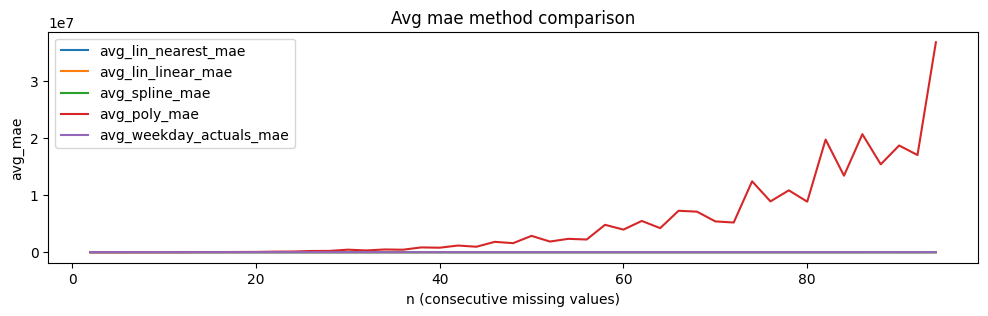

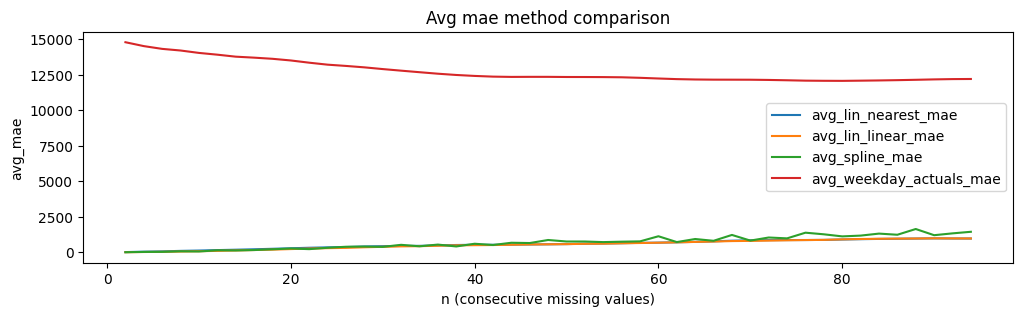

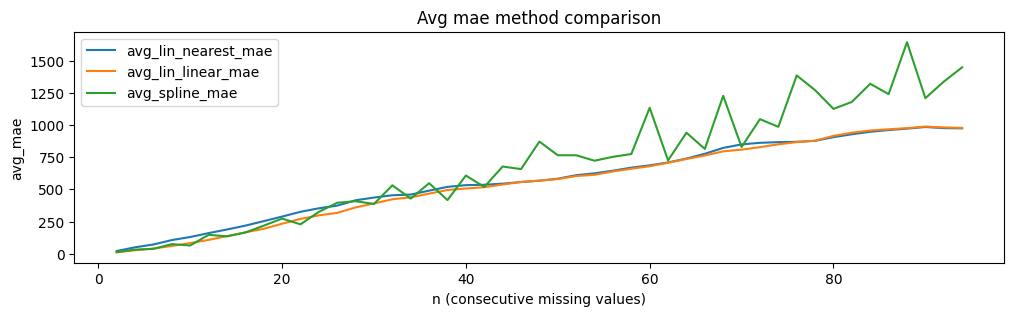

In [16]:
def plot_impute_methods(impute_methods):
    _ = plt.figure(figsize=(12, 3))
    for method in impute_methods:  
        
        _ = sns.lineplot(
            data=final_results, 
            x='n', 
            y=method,
            #color=color,
            #linewidth=0.25,
            label=method)
        _ = plt.xlabel('n (consecutive missing values)')
        _ = plt.ylabel('avg_mae')
        _ = plt.title(f'Avg mae method comparison')

    plt.show()
impute_methods = ['avg_lin_nearest_mae', 'avg_lin_linear_mae', 'avg_spline_mae', 'avg_poly_mae', 'avg_weekday_actuals_mae']
plot_impute_methods(impute_methods)

impute_methods_2 = ['avg_lin_nearest_mae', 'avg_lin_linear_mae', 'avg_spline_mae',  'avg_weekday_actuals_mae']
plot_impute_methods(impute_methods_2)

impute_methods_3 = ['avg_lin_nearest_mae', 'avg_lin_linear_mae', 'avg_spline_mae']
plot_impute_methods(impute_methods_3)


In [68]:
### Goal: Use Nixtla ETS model to forecast gaps
# 1. Randomly place gaps in dataset of size n = 4 through 96

### --- This is the dataframe for testing --- ###

# To reflect actual data and favor this forecasting imputation
# method, ensuring first x rows of data are available. 

# 1 day = 96 rows, 1 month = 96 * 30 = 2880
impute_data['to_impute'] = impute_data['load_actual_entsoe_transparency']
complete_range = impute_data.iloc[0:2879]
impute_range = impute_data.iloc[2879:]
nan_window = list(range(2, 96+1, 2)) # (gaps of size 2 to 96 by 2)
impute_indices = list(impute_range.sample(len(nan_window), random_state=24).index)

# -------- This method does not seem to impute enough nans
for idx, num_nan in zip(impute_indices, nan_window):
    impute_range.iloc[idx:idx+num_nan] = np.nan


### num nan should be very close to 
# (possibility of overlapping windows)
check_nan_num = sum(list(range(2,96+1,2))) 
actual_nan_num = sum(impute_range['to_impute'].isna())

# NA in df is not close to the expected number... 
print(f"Imputed NA num: {check_nan_num}, NA in df: {actual_nan_num}")

# no gaps are large enough to correspond to this difference
final_impute_df = pd.concat([complete_range, impute_range])

Imputed NA num: 2352, NA in df: 2281


Investigating difference in number of NAs

In [18]:
idx_gap_pairs = pd.DataFrame({
    'idx': impute_indices,
    'n_gap_size': nan_window
    })

lag_test = pd.DataFrame({
    'sorted': sorted(impute_indices)
    })

lag_test['sorted_lag'] = lag_test['sorted'].shift()
lag_test['diff'] = lag_test['sorted'] - lag_test['sorted_lag']

final_tbl = (lag_test.merge(
    idx_gap_pairs, 
    left_on='sorted', 
    right_on='idx', 
    how='left')
    [['sorted', 'diff', 'n_gap_size']])

# Cases where the gap is greter than the different, 
# causeing there to be fewer than expected NAs
final_tbl.loc[lambda x: x['diff'] <= x['n_gap_size']]

,sorted,diff,n_gap_size
8,35133,19.0,68


This above table explains a portion of the gap between expected NAs and actual NAs
in the dataframe. 

NA_gap = 2352 - 2281 = 71  
Expected missing NAs = 68 - 19 = 49

Unfortunately, 71 - 49 = 22 missing NAs unexpectedly exist. Currently unaware of their origin.

In [69]:
from statsforecast import StatsForecast
from statsforecast.models import AutoETS


### Check if function can forecast with the non-na values - what happens?
# If it breaks, remove the two prior to forecasting, then recombine later

# indice of first NA value
impute_info = create_impute_groups(final_impute_df, 'load_actual_entsoe_transparency') 
impute_info.head()

first_na = impute_info['first_na_idx'].iloc[0] # for later: final_impute_df

# Defining start, end, and horizon points of training window
one_year_data = 2880 * 12 # Selecting all data available, up to 1 year
start = max(first_na - one_year_data, 0)  
end = first_na - 1

horizon = impute_info['consecutive'].iloc[0]

print(f"first_na: {first_na}, one_year_idx: {one_year_data}",
      f"suggested start: {first_na - one_year_data},",
      f"start: {start}, end: {end}, horizon: {horizon}")

# trying freq=1 assuming one is the number of rows
# the horizon may be an alternative?
impute_model = StatsForecast(
    models=[AutoETS(model="AAA", season_length=96)], # --- season_length=96 (1 day) or maybe 1 week
    freq='15min',
    n_jobs=-1,
    verbose=True
    ) 

# forecast imputed values with forecast df
import time
begin_timing = time.time()
fcst_df = (final_impute_df.iloc[start:end] # index may need to be reset
           #.reset_index()
           #.assign(index = lambda x: x['index'].astype('category'))
           .assign(index = 1)
           [['index', 'utc_timestamp', 'to_impute']]) 

fcst_df.dtypes
fcst_df.shape 

result = impute_model.forecast(
    df=fcst_df, 
    id_col='index',
    time_col='utc_timestamp',
    target_col='to_impute',
    h=horizon
    ).rename(columns={'AutoETS': 'imputed'})

total_time = time.time() - start 

result.head()
# print(f"Total time to train AutoETS Model to impute {horizon} nans ",
#       f"given dataset of size {len(fcst_df)}: {total_time:2f} seconds")

# place imputation into the data from for the given indice range

,missing_group_num,consecutive,first_na_idx,last_na_idx
1,1,24,6052,6077
2,2,60,6601,6662
3,3,50,11487,11538
4,4,36,20487,20524
5,5,82,26193,26276


first_na: 6052, one_year_idx: 34560 suggested start: -28508, start: 0, end: 6051, horizon: 24


index                          int64
utc_timestamp    datetime64[ns, UTC]
to_impute                    float64
dtype: object

(6051, 3)

Forecast:   0%|          | 0/1 [00:00<?, ?it/s]

,index,utc_timestamp,imputed
0,1,2015-03-05 00:00:00+00:00,7016.370734
1,1,2015-03-05 00:15:00+00:00,6931.056460
2,1,2015-03-05 00:30:00+00:00,6948.100639
3,1,2015-03-05 00:45:00+00:00,6887.453011
4,1,2015-03-05 01:00:00+00:00,6888.810414
